In [1]:
# Object Detecion 
import cv2
from ultralytics import YOLO
#plots
import matplotlib.pyplot as plt
import seaborn as sns

#basics
import pandas as pd
import numpy as np
import os
import subprocess

from tqdm import tqdm

cam1_path = '/七贤岭/417334'
cam2_path = '/七贤岭/417290'
cam1_size = len(os.listdir(cam1_path))
# vid_name = os.listdir(cam1_path)[cam1_size // 2]
vid_name = 'qx334_231208_100348_100449.mp4'
path = os.path.join(cam1_path, vid_name)

print(path)

/七贤岭/417334/qx334_231208_100348_100449.mp4


In [2]:
video = cv2.VideoCapture(path)
fps = 12
length = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
duration = length / fps
print(fps)
print(length)
print(duration)

12
720
60.0


In [3]:
# 从文件名中提取日期和时间
vid1_date = vid_name.split('_')[1]
vid1_time_start = vid_name.split('_')[2][:-2]
vid1_time_start_hour = int(vid1_time_start[:2])
vid1_time_start_minute = vid1_time_start_hour*60 + int(vid1_time_start[2:])


vid1_time_end = vid_name.split('_')[3][:-4][:-2]
vid1_time_end_hour = int(vid1_time_end[:2])
vid1_time_end_minute = vid1_time_end_hour*60 + int(vid1_time_end[2:])

print(vid1_date)

# 0点开始的分钟数
print(vid1_time_start_minute, vid1_time_end_minute)

vid1_datetime_start = pd.to_datetime(vid1_date, yearfirst=True) + pd.Timedelta(minutes=vid1_time_start_minute, seconds=int(vid_name.split('_')[2][-2:]))
vid1_datetime_end = pd.to_datetime(vid1_date, yearfirst=True) + pd.Timedelta(minutes=vid1_time_end_minute, seconds=int(vid_name.split('_')[3][-6:-4]))
print(vid1_datetime_start, vid1_datetime_end)

231208
603 604
2023-12-08 10:03:48 2023-12-08 10:04:49


# 对query视频进行track，并将所有人加入数据库

In [4]:
# 开始track并编码
model = YOLO('/root/yolov8x.pt')
track_results_vid1 = model.track(path, classes=0, persist=True)



WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/720) /七贤岭/417334/qx334_231208_100348_100449.mp4: 384x640 2 persons, 124.3ms
video 1/1 (frame 2/720) /七贤岭/417334/qx334_231208_100348_100449.mp4: 384x640 2 persons, 10.9ms
video 1/1 (frame 3/720) /七贤岭/417334/qx334_231208_100348_100449.mp4: 384x640 2 persons, 10.9ms
video 1/1 (frame 4/720) /七贤岭/417334/qx334_231208_100348_100449.mp4: 384x640 2 persons, 10.9ms
video 1/1 (frame 5/720) /七贤岭/417334/qx334_231208_100348_100449.mp4: 384x640 2 p

In [5]:
# 特征提取器
from torchreid.reid.utils import FeatureExtractor

extractor = FeatureExtractor(
    model_name='osnet_x1_0',
    model_path='/root/osnet_x1_0_imagenet.pth',
    device='cuda'
)

/usr/local/miniconda3/lib/python3.8/site-packages/torchreid/reid/metrics/rank.py:11: UserWarning: Cython evaluation (very fast so highly recommended) is unavailable, now use python evaluation.
  warnings.warn(


Model: osnet_x1_0
- params: 2,193,616
- flops: 978,878,352
Successfully loaded pretrained weights from "/root/osnet_x1_0_imagenet.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.weight', 'classifier.bias']


In [6]:
# add_ids = set()
embeddings = {}
infos = {}

# people_set = set([1., 2.])
# color_dict = {1.: (0, 255, 0), 2.: (0, 0, 255)}
# flag = 1
# vid1_imgs = []

# 对每一帧，如果该id没有在index，就crop出来，添加到faiss index里。
for idx, fr in enumerate(track_results_vid1[:]):
    box_num = fr.boxes.cls.shape[0]
    
    # 如果有人
    if box_num > 0:
        img = fr.orig_img.copy()
        for i in range(box_num):
            # 如果有id
            if fr.boxes.id is not None:
                x1, y1, x2, y2 = fr.boxes.xyxy[i]
                crop = fr.orig_img[int(y1):int(y2), int(x1):int(x2)]
                extract = extractor(crop).cpu().numpy()
                embeddings[fr.boxes.id[i].item()] = embeddings[fr.boxes.id[i].item()] + [extract] if fr.boxes.id[i].item() in embeddings else [extract]

In [7]:
# vector search
import faiss
index_vid1 = faiss.IndexFlatL2(512)

for key in embeddings:
    embeddings[key] = np.array(embeddings[key])
    index_vid1.add(embeddings[key].mean(axis=0).reshape(1, -1))

In [8]:
index_vid1.ntotal

25

# 对search范围内视频分段进行tracking，对每一个框进行编码。设置阈值，若某张图片超过阈值，则将id绑定

In [9]:
timelapse = 2 # +-2min
vid2_date = vid1_date
vid2_time_start = vid1_time_start_minute - timelapse
vid2_time_end = vid1_time_end_minute + timelapse
print(vid2_time_start, vid2_time_end)

vid2s = []

for vid2 in os.listdir(cam2_path):
    if not vid2.endswith('.mp4'):
        continue
    vid2_time = vid2.split('_')[2][:-2]
    vid2_time_hour = int(vid2_time[:2])
    vid2_time_minute = vid2_time_hour*60 + int(vid2_time[2:])
    
    if vid2_time_minute >= vid2_time_start and vid2_time_minute <= vid2_time_end:
        print(vid2)
        vid2s.append(vid2)

601 606
qx290_231208_100109_100210.mp4
qx290_231208_100210_100310.mp4
qx290_231208_100310_100411.mp4
qx290_231208_100411_100512.mp4
qx290_231208_100512_100613.mp4
qx290_231208_100613_100714.mp4


In [10]:
def matching(track_result, vid1_faiss, threshold_distance=200):
    embs = {}
    maxid = -1
    for idx, fr in enumerate(track_result):
        box_num = fr.boxes.cls.shape[0]
        for i in range(box_num):
            # print(fr.boxes.id)
            if fr.boxes.id is not None:
                x1, y1, x2, y2 = fr.boxes.xyxy[i]
                crop = fr.orig_img[int(y1):int(y2), int(x1):int(x2)]
                extract = extractor(crop).cpu().numpy()
                embs[fr.boxes.id[i].item()] = embs[fr.boxes.id[i].item()] + [extract] if fr.boxes.id[i].item() in embs else [extract]
    for key in embs:
        embs[key] = np.array(embs[key])
        embs[key] = embs[key].mean(axis=0).reshape(1, -1)
    
    all_embs = [embs[key] for key in embs.keys()]
    if len(all_embs) == 0:
        return {}, -1
    maxid = max(embs.keys())
    all_embs = np.vstack([embs[key] for key in embs.keys()])
    
    # search and print distance
    D, I = vid1_faiss.search(all_embs, 1)
    # return D, I
    for idx, key in enumerate(embs.keys()):
        print(f"ID: {key}, Nearest Neighbors: {I[idx]}, Distances: {D[idx]}")
    # map all embs to their nearest neighbors if distance < threshold
    matched = {}
    for idx, key in enumerate(embs.keys()):
        if D[idx] < threshold_distance:
            matched[key] = I[idx][0]
    return matched, maxid


In [16]:
mappings = {}
# all_results = []
maxid = -1
threshold_distance = 200
import pickle

idx = 0

for vid2_name in tqdm(vid2s):
    vid2_path = os.path.join(cam2_path, vid2_name)
    print(vid2_path)
    # track silently
    track_results = model.track(vid2_path, classes=0, persist=True, verbose=False)
    # save to file
    pickle.dump(track_results, open(f'/hy-tmp/{idx}.pkl', 'wb+'))
    # all_results.append(track_results.box_results)
    res, maxid_ = matching(track_results, index_vid1, threshold_distance=threshold_distance)
    maxid = max(maxid, maxid_)
    if res:
        mappings = {**mappings, **res}
    print(res)
    idx += 1
            # img = fr.orig_img.copy()
            # for i in range(box_num):
            #     if fr.boxes.id is not None:
            #         x1, y1, x2, y2 = fr.boxes.xyxy[i]
            #         crop = fr.orig_img[int(y1):int(y2), int(x1):int(x2)]
            #         extract = extractor(crop)
            #         index.add(extract.cpu().numpy())
            #         time = vid1_datetime_start + pd.Timedelta(seconds=idx/fps)
            #         infos.append({'img': crop, 'size':(x2-x1)*(y2-y1), 'time':time, 'id': fr.boxes.id[i].item()})
print(mappings)

  0%|          | 0/6 [00:00<?, ?it/s]

/七贤岭/417290/qx290_231208_100109_100210.mp4

WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs



 17%|█▋        | 1/6 [00:12<01:02, 12.53s/it]

{}
/七贤岭/417290/qx290_231208_100210_100310.mp4

WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs



 33%|███▎      | 2/6 [00:26<00:54, 13.64s/it]

ID: 60.0, Nearest Neighbors: [15], Distances: [     276.16]
ID: 62.0, Nearest Neighbors: [15], Distances: [     363.97]
ID: 63.0, Nearest Neighbors: [15], Distances: [     450.33]
ID: 64.0, Nearest Neighbors: [15], Distances: [        169]
{64.0: 15}
/七贤岭/417290/qx290_231208_100310_100411.mp4

WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs



[aac @ 0x55ee2a41ae00] TNS filter order 19 is greater than maximum 12.
 50%|█████     | 3/6 [00:49<00:53, 17.77s/it]

ID: 65.0, Nearest Neighbors: [13], Distances: [     287.75]
ID: 66.0, Nearest Neighbors: [1], Distances: [     470.58]
ID: 67.0, Nearest Neighbors: [1], Distances: [     143.65]
ID: 68.0, Nearest Neighbors: [15], Distances: [     238.47]
ID: 70.0, Nearest Neighbors: [15], Distances: [      100.2]
{67.0: 1, 70.0: 15}
/七贤岭/417290/qx290_231208_100411_100512.mp4

WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs



 67%|██████▋   | 4/6 [01:06<00:34, 17.49s/it]

ID: 71.0, Nearest Neighbors: [23], Distances: [     101.46]
ID: 72.0, Nearest Neighbors: [24], Distances: [      146.7]
{71.0: 23, 72.0: 24}
/七贤岭/417290/qx290_231208_100512_100613.mp4

WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs



[aac @ 0x55ee324253c0] TNS filter order 14 is greater than maximum 12.
 83%|████████▎ | 5/6 [01:24<00:17, 17.68s/it]

ID: 74.0, Nearest Neighbors: [21], Distances: [     195.17]
ID: 75.0, Nearest Neighbors: [15], Distances: [     196.86]
{74.0: 21, 75.0: 15}
/七贤岭/417290/qx290_231208_100613_100714.mp4

WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs



[aac @ 0x55ee2ba5bc80] TNS filter order 14 is greater than maximum 12.
100%|██████████| 6/6 [02:14<00:00, 22.47s/it]

ID: 76.0, Nearest Neighbors: [6], Distances: [      130.4]
ID: 77.0, Nearest Neighbors: [3], Distances: [     187.97]
ID: 78.0, Nearest Neighbors: [21], Distances: [     189.62]
ID: 79.0, Nearest Neighbors: [21], Distances: [     241.56]
ID: 80.0, Nearest Neighbors: [23], Distances: [     271.78]
ID: 81.0, Nearest Neighbors: [17], Distances: [     314.47]
ID: 82.0, Nearest Neighbors: [17], Distances: [     262.77]
ID: 83.0, Nearest Neighbors: [8], Distances: [     589.83]
ID: 84.0, Nearest Neighbors: [21], Distances: [     146.69]
{76.0: 6, 77.0: 3, 78.0: 21, 84.0: 21}
{64.0: 15, 67.0: 1, 70.0: 15, 71.0: 23, 72.0: 24, 74.0: 21, 75.0: 15, 76.0: 6, 77.0: 3, 78.0: 21, 84.0: 21}


In [19]:
maxid

84.0

In [20]:
max_ids = int(maxid)
# create random colors of max_ids
color_table = {i: tuple(np.random.randint(0, 255, 3)) for i in range(1, max_ids + 1)}
color_table

{1: (119, 5, 141),
 2: (138, 67, 87),
 3: (70, 171, 236),
 4: (153, 227, 26),
 5: (126, 156, 77),
 6: (223, 21, 67),
 7: (112, 91, 184),
 8: (178, 158, 21),
 9: (223, 8, 99),
 10: (48, 194, 104),
 11: (193, 113, 55),
 12: (179, 29, 185),
 13: (250, 1, 134),
 14: (100, 209, 170),
 15: (207, 11, 236),
 16: (146, 165, 71),
 17: (15, 195, 158),
 18: (234, 158, 147),
 19: (44, 195, 191),
 20: (205, 134, 104),
 21: (84, 155, 106),
 22: (193, 206, 4),
 23: (171, 244, 103),
 24: (82, 30, 171),
 25: (132, 134, 11),
 26: (122, 114, 145),
 27: (82, 129, 197),
 28: (42, 103, 91),
 29: (38, 66, 247),
 30: (31, 212, 137),
 31: (60, 75, 43),
 32: (51, 150, 6),
 33: (6, 52, 43),
 34: (88, 240, 186),
 35: (126, 240, 165),
 36: (11, 55, 149),
 37: (211, 153, 77),
 38: (183, 21, 231),
 39: (150, 13, 221),
 40: (227, 92, 236),
 41: (39, 176, 216),
 42: (23, 49, 34),
 43: (102, 242, 117),
 44: (85, 65, 196),
 45: (35, 49, 3),
 46: (134, 154, 178),
 47: (165, 2, 83),
 48: (222, 118, 191),
 49: (44, 133, 68)

In [21]:
# 输出视频

# vid1_imgs = []
width = 1920
height = 1080
# output video
output_path = './temp/'
if not os.path.exists(output_path):
    os.makedirs(output_path)
output_name = os.path.join(output_path, 'multi_vid2.mp4')
print(output_name)

VIDEO_CODEC = "mp4v"

output_video = cv2.VideoWriter(output_name, 
                               cv2.VideoWriter_fourcc(*VIDEO_CODEC), 
                               fps, (width, height))

result_pickle = pickle.load(open(f'/hy-tmp/5.pkl', 'rb'))

for fr in result_pickle:
    box_num = fr.boxes.cls.shape[0]
    img = fr.orig_img.copy()
    if box_num > 0:
        # break
        for i in range(box_num):
            _, _, w, h = fr.boxes.xywh[i]
            if fr.boxes.id is not None:
                # crop
                x1, y1, x2, y2 = fr.boxes.xyxy[i]
                # draw rectangle
                if fr.boxes.id[i].item() in mappings:
                    color = color_table[mappings[fr.boxes.id[i].item()]]
                    text = f"ID matched: {mappings[fr.boxes.id[i].item()]} !"
                    text_color = (0, 0, 255)
                else:
                    color = color_table[fr.boxes.id[i].item()]
                    text = f"ID: {fr.boxes.id[i].item()}"
                    text_color = (255, 0, 0)
                img = cv2.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), (int(color[0]), int(color[1]), int(color[2])), 10)
                # add id
                # auto adjust text position, if the text is out of the image, move it to another side of the box which has more space
                if y1 < 50:
                    y1 = y2
                if x1 < 50:
                    x1 = x2

                img = cv2.putText(img, text, (int(x1), int(y1)), cv2.FONT_HERSHEY_SIMPLEX, 1, text_color, 2, cv2.LINE_AA)  
    output_video.write(img)

output_video.release()

./temp/multi_vid2.mp4


(tuple, tuple)

In [89]:
# # use ffmpeg to concat all videos into a single video
# with open('temp/vid2.txt', 'w') as f:
#     for vid2 in vid2s:
#         f.write(f"file '{os.path.join(cam2_path, vid2)}'\n")
# cmd = f"ffmpeg -f concat -safe 0 -i temp/vid2.txt -c copy {output_name} -y"

In [ ]:
# os.system(cmd)

In [ ]:
# # 对范围进行track
# track_model_vid2 = YOLO('/root/yolov8x.pt')
# track_results_vid2 = track_model_vid2.track(output_name, classes=0, persist=True)

In [8]:
# Object Detecion 
import cv2
from ultralytics import YOLO
#plots
import matplotlib.pyplot as plt
import seaborn as sns

#basics
import pandas as pd
import numpy as np
import os
import subprocess

from tqdm import tqdm

#loading a YOLO model from disk
model = YOLO('/root/yolov8x.pt')


#geting names from classes
dict_classes = model.model.names

### Configurations
# Scaling percentage of original frame
scale_percent = 100
#-------------------------------------------------------
# Reading video with cv2
output_name = '/root/YOLO-ViT-PGC/temp/merged.mp4'
video = cv2.VideoCapture(output_name)

# Objects to detect Yolo
class_IDS = [0] 
# Auxiliary variables
centers_old = {}


# Original informations of video
height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
fps = video.get(cv2.CAP_PROP_FPS)
print('[INFO] - Original Dim: ', (width, height))

# Scaling Video for better performance 
if scale_percent != 100:
    print('[INFO] - Scaling change may cause errors in pixels lines ')
    width = int(width * scale_percent / 100)
    height = int(height * scale_percent / 100)
    print('[INFO] - Dim Scaled: ', (width, height))

[INFO] - Original Dim:  (1920, 1080)


[aac @ 0x55d0c4414800] TNS filter order 19 is greater than maximum 12.


In [9]:
from torchreid.reid.utils import FeatureExtractor

extractor = FeatureExtractor(
    model_name='osnet_x1_0',
    model_path='/root/osnet_x1_0_imagenet.pth',
    device='cuda'
)

/usr/local/miniconda3/lib/python3.8/site-packages/torchreid/reid/metrics/rank.py:11: UserWarning: Cython evaluation (very fast so highly recommended) is unavailable, now use python evaluation.
  warnings.warn(


Model: osnet_x1_0
- params: 2,193,616
- flops: 978,878,352
Successfully loaded pretrained weights from "/root/osnet_x1_0_imagenet.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.weight', 'classifier.bias']


  0%|          | 0/376 [00:00<?, ?it/s]


0: 384x640 1 person, 10.9ms
Speed: 1.5ms preprocess, 10.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 10.9ms
Speed: 2.3ms preprocess, 10.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 12.5ms
Speed: 2.8ms preprocess, 12.5ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 11.5ms
Speed: 2.5ms preprocess, 11.5ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 10.9ms
Speed: 2.8ms preprocess, 10.9ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 12.6ms
Speed: 2.8ms preprocess, 12.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.8ms
Speed: 2.3ms preprocess, 11.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 10.9ms
Speed: 1.6ms preprocess, 10.9ms inference, 1.1ms postprocess per ima

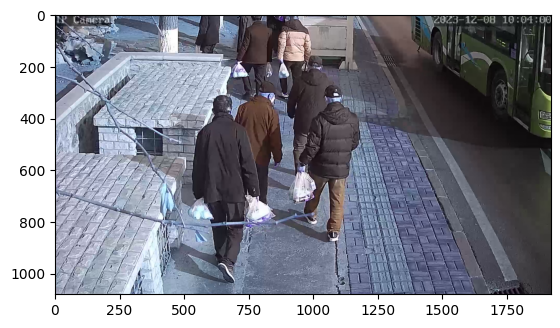


0: 384x640 3 persons, 10.9ms
Speed: 1.5ms preprocess, 10.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 12.7ms
Speed: 2.9ms preprocess, 12.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 11.4ms
Speed: 2.3ms preprocess, 11.4ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 12.2ms
Speed: 2.3ms preprocess, 12.2ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 10.9ms
Speed: 2.3ms preprocess, 10.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 11.2ms
Speed: 2.7ms preprocess, 11.2ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 11.7ms
Speed: 2.7ms preprocess, 11.7ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 10.9ms
Speed: 2.7ms preprocess, 10.9ms inference, 0.5ms postprocess per image 

In [15]:
# vector search
import faiss
index = faiss.IndexFlatL2(512)

%matplotlib inline
# get frame per 2 seconds
frame_interval = int(fps * 2)
infos = []
# tqdm
from tqdm.notebook import trange
for idx in trange(0, int(video.get(cv2.CAP_PROP_FRAME_COUNT)), frame_interval):
    video.set(cv2.CAP_PROP_POS_FRAMES, idx)
    ret, frame = video.read()
    # bgr to rgb
    # frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    if not ret:
        break
    # detect objects in the frame, conf>0.5
    results = model(frame, classes=class_IDS, conf=0.8)
    for r in results:
        # print(r)
        # print(r.boxes.xywh)
        box_num = r.boxes.cls.shape[0]
        if box_num:
            for i in range(box_num):
                _, _, w, h = r.boxes.xywh[i]
                if w <= h: 
                    # has detections and is a vertical rectangle
                    # crop
                    x1, y1, x2, y2 = r.boxes.xyxy[i]
                    crop = frame[int(y1):int(y2), int(x1):int(x2)]
                    # show the crop
                    # plt.imshow(crop)
                    # plt.show()
                    extract = extractor(crop)
                    # print(extract.shape)
                    # print(extract)
                    index.add(extract.cpu().numpy())
                    infos.append({
                        'img': crop,
                        'time': start_time + datetime.timedelta(seconds=idx // fps),
                        'frame': idx,
                        'pos': (x1, y1, x2, y2)
                    })
            if box_num >= 5:
                print(start_time + datetime.timedelta(seconds=idx // fps))
                plt.imshow(frame)
                plt.show()
                    # show the frame
                    # plt.imshow(r.plot())
                    # plt.show()
    

In [11]:
index.ntotal

236

In [12]:
print(len(infos))
infos[:5]

236


[{'img': array([[[114, 127, 146],
          [111, 124, 143],
          [126, 139, 158],
          ...,
          [ 72,  60,  59],
          [ 72,  60,  59],
          [ 72,  60,  59]],
  
         [[148, 161, 180],
          [158, 171, 190],
          [155, 168, 187],
          ...,
          [ 72,  60,  59],
          [ 72,  60,  59],
          [ 72,  60,  59]],
  
         [[152, 165, 184],
          [153, 166, 185],
          [153, 166, 185],
          ...,
          [ 69,  60,  58],
          [ 69,  60,  58],
          [ 69,  60,  58]],
  
         ...,
  
         [[ 38,  35,  42],
          [ 37,  34,  41],
          [ 46,  43,  50],
          ...,
          [ 80,  81, 102],
          [ 80,  81, 102],
          [ 84,  85, 106]],
  
         [[ 53,  50,  57],
          [ 51,  48,  55],
          [ 49,  46,  53],
          ...,
          [ 80,  81, 102],
          [ 80,  81, 102],
          [ 83,  84, 105]],
  
         [[ 68,  65,  73],
          [ 69,  66,  74],
          [ 71,  

# 以上是进行数据库建立，接下来在视频中并在数据库查找最相近的人

In [13]:
model = YOLO('/root/yolov8x.pt')
track_results = model.track(path, classes=0, persist=True)



WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/720) /七贤岭/417290/qx290_231208_100613_100714.mp4: 384x640 (no detections), 11.4ms
video 1/1 (frame 2/720) /七贤岭/417290/qx290_231208_100613_100714.mp4: 384x640 (no detections), 10.8ms
video 1/1 (frame 3/720) /七贤岭/417290/qx290_231208_100613_100714.mp4: 384x640 (no detections), 10.9ms
video 1/1 (frame 4/720) /七贤岭/417290/qx290_231208_100613_100714.mp4: 384x640 (no detections), 10.8ms
video 1/1 (frame 5/720) /七贤岭/417290/qx290_231208_100613_

[aac @ 0x55d0c49fb100] TNS filter order 14 is greater than maximum 12.


video 1/1 (frame 9/720) /七贤岭/417290/qx290_231208_100613_100714.mp4: 384x640 (no detections), 10.9ms
video 1/1 (frame 10/720) /七贤岭/417290/qx290_231208_100613_100714.mp4: 384x640 (no detections), 11.3ms
video 1/1 (frame 11/720) /七贤岭/417290/qx290_231208_100613_100714.mp4: 384x640 (no detections), 10.9ms
video 1/1 (frame 12/720) /七贤岭/417290/qx290_231208_100613_100714.mp4: 384x640 (no detections), 10.0ms
video 1/1 (frame 13/720) /七贤岭/417290/qx290_231208_100613_100714.mp4: 384x640 (no detections), 9.5ms
video 1/1 (frame 14/720) /七贤岭/417290/qx290_231208_100613_100714.mp4: 384x640 (no detections), 9.5ms
video 1/1 (frame 15/720) /七贤岭/417290/qx290_231208_100613_100714.mp4: 384x640 (no detections), 9.6ms
video 1/1 (frame 16/720) /七贤岭/417290/qx290_231208_100613_100714.mp4: 384x640 (no detections), 9.6ms
video 1/1 (frame 17/720) /七贤岭/417290/qx290_231208_100613_100714.mp4: 384x640 (no detections), 10.5ms
video 1/1 (frame 18/720) /七贤岭/417290/qx290_231208_100613_100714.mp4: 384x640 (no detections), 9.

./temp/vid1.mp4


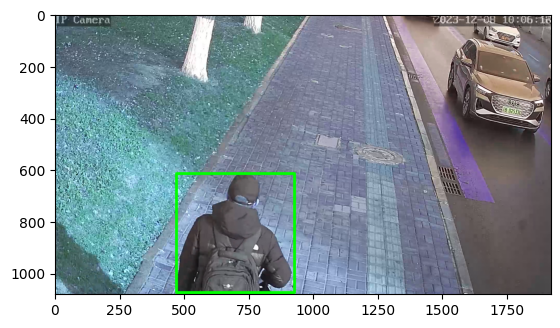

2023-12-08 10:05:12


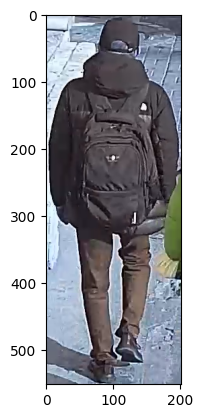

In [59]:
people_set = set([1., 2.])
color_dict = {1.: (0, 255, 0), 2.: (0, 0, 255)}
flag = 1
# vid1_imgs = []

# output video
output_path = './temp/'
if not os.path.exists(output_path):
    os.makedirs(output_path)
output_name = os.path.join(output_path, 'vid1.mp4')
print(output_name)

VIDEO_CODEC = "mp4v"

output_video = cv2.VideoWriter(output_name, 
                               cv2.VideoWriter_fourcc(*VIDEO_CODEC), 
                               fps, (width, height))

for fr in track_results[:]:
    box_num = fr.boxes.cls.shape[0]
    if box_num > 0:
        # break
        img = fr.orig_img.copy()
        for i in range(box_num):
            _, _, w, h = fr.boxes.xywh[i]
            if w <= h and (fr.boxes.id is not None) and fr.boxes.id[i].item() in people_set: 
                # print(fr.boxes.id[i].item())
                # has detections and is a vertical rectangle
                # crop
                x1, y1, x2, y2 = fr.boxes.xyxy[i]
                crop = fr.orig_img[int(y1):int(y2), int(x1):int(x2)]
                # print(fr.boxes)
                
                # bgr to rgb
                # img = cv2.cvtColor(fr.orig_img, cv2.COLOR_BGR2RGB)

                # output_video.write(fr.plot())

                # add ori_img with box
                
                if flag:
                    flag -= 1
                    plt.imshow(img)
                    plt.show()
                    extract = extractor(crop)
                    # find in index
                    D, I = index.search(extract.cpu().numpy(), 1)
                    # print(D, I)
                    # show infos
                    for j in I[0]:
                        print(infos[j]['time'])
                        search_time = infos[j]['time']
                        search_I = I
                        plt.imshow(infos[j]['img'])
                        plt.show()
                # print(fr.boxes.id[i].item())
                img = cv2.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), color_dict[fr.boxes.id[i].item()], 10)
        
        flag_ = False
        if fr.boxes.id is not None:
            for id_ in fr.boxes.id:
                if id_.item() in people_set:
                    flag_ = True
                    break
        if flag_:
            output_video.write(img)        

output_video.release()

In [14]:
search_time

datetime.datetime(2023, 12, 8, 10, 5, 12)

In [15]:
for vid in vid2s:
    vid_name = os.path.join(cam2_path, vid)
    vid_date = vid_name.split('_')[1]
    vid_time_start = vid_name.split('_')[2]
    vid_time_start_hour = int(vid_time_start[:2])
 

    vid_time_end = vid_name.split('_')[3][:-4]
    vid_time_end_hour = int(vid_time_end[:2])


    vid_start_datetime = datetime.datetime(int('20' + vid_date[:2]), int(vid_date[2:-2]), int(vid_date[-2:]), vid_time_start_hour, int(vid_time_start[2:4]), int(vid_time_start[4:]))
    vid_end_datetime = datetime.datetime(int('20' + vid_date[:2]), int(vid_date[2:-2]), int(vid_date[-2:]), vid_time_end_hour, int(vid_time_end[2:4]), int(vid_time_end[4:]))

    if search_time >= vid_start_datetime and search_time <= vid_end_datetime:
        print(vid_name)
        vid2_search_start_datetime = vid_start_datetime
        vid2_fine = vid_name
        break

/hy-tmp/七贤岭/417334/qx334_231208_100449_100549.mp4


In [37]:
model = YOLO('/root/yolov8x.pt')
vid2_track_results = model.track(vid2_fine, classes=0, persist=True)



WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/720) /hy-tmp/七贤岭/417334/qx334_231208_100449_100549.mp4: 384x640 1 person, 17.5ms
video 1/1 (frame 2/720) /hy-tmp/七贤岭/417334/qx334_231208_100449_100549.mp4: 384x640 1 person, 13.1ms


[aac @ 0x563a3a2a2200] TNS filter order 18 is greater than maximum 12.


video 1/1 (frame 3/720) /hy-tmp/七贤岭/417334/qx334_231208_100449_100549.mp4: 384x640 1 person, 13.0ms
video 1/1 (frame 4/720) /hy-tmp/七贤岭/417334/qx334_231208_100449_100549.mp4: 384x640 1 person, 12.9ms
video 1/1 (frame 5/720) /hy-tmp/七贤岭/417334/qx334_231208_100449_100549.mp4: 384x640 1 person, 12.1ms
video 1/1 (frame 6/720) /hy-tmp/七贤岭/417334/qx334_231208_100449_100549.mp4: 384x640 1 person, 11.7ms
video 1/1 (frame 7/720) /hy-tmp/七贤岭/417334/qx334_231208_100449_100549.mp4: 384x640 1 person, 12.8ms
video 1/1 (frame 8/720) /hy-tmp/七贤岭/417334/qx334_231208_100449_100549.mp4: 384x640 1 person, 12.8ms
video 1/1 (frame 9/720) /hy-tmp/七贤岭/417334/qx334_231208_100449_100549.mp4: 384x640 1 person, 12.8ms
video 1/1 (frame 10/720) /hy-tmp/七贤岭/417334/qx334_231208_100449_100549.mp4: 384x640 1 person, 12.7ms
video 1/1 (frame 11/720) /hy-tmp/七贤岭/417334/qx334_231208_100449_100549.mp4: 384x640 1 person, 13.0ms
video 1/1 (frame 12/720) /hy-tmp/七贤岭/417334/qx334_231208_100449_100549.mp4: 384x640 1 person, 12.7

In [38]:
vid2_search_start_datetime

datetime.datetime(2023, 12, 8, 10, 4, 49)

273


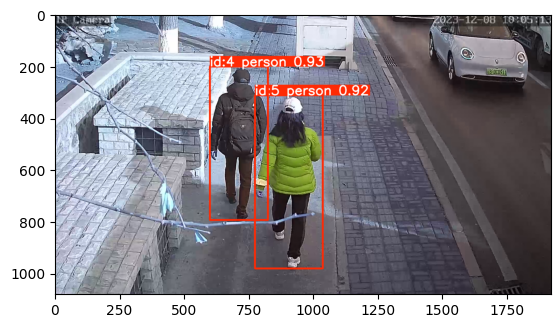

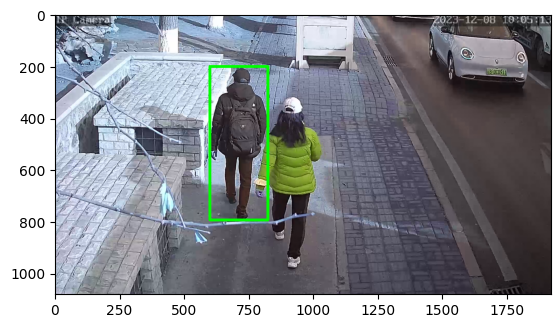

tensor(0.7270, device='cuda:0')
(tensor(607.5005, device='cuda:0'), tensor(160.5087, device='cuda:0'), tensor(808.9521, device='cuda:0'), tensor(712.0057, device='cuda:0'))
tensor(598.3677) tensor(202.2643) tensor(822.5816) tensor(794.7094)
tensor(4.)


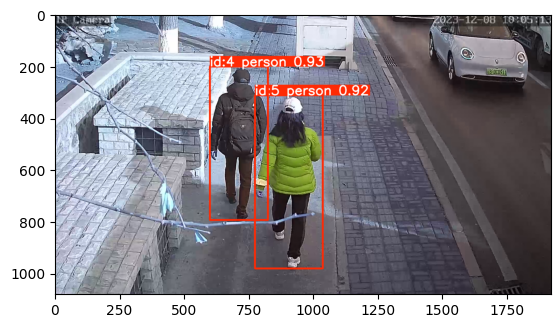

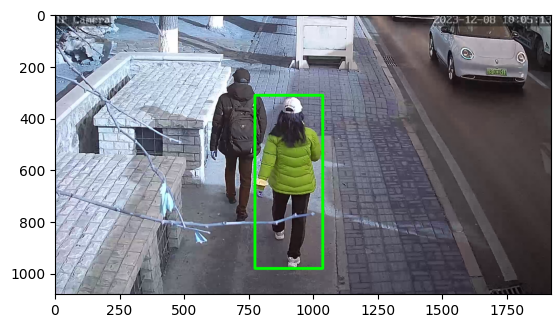

tensor(0.0531, device='cuda:0')
(tensor(607.5005, device='cuda:0'), tensor(160.5087, device='cuda:0'), tensor(808.9521, device='cuda:0'), tensor(712.0057, device='cuda:0'))
tensor(772.8282) tensor(313.2869) tensor(1034.2635) tensor(981.3243)
tensor(4.)


In [44]:
flag = False

delta = search_time - vid2_search_start_datetime

# to frame
delta_frame = int(delta.total_seconds() * fps)
print(delta_frame)

# print(infos[search_I[0][0]]['pos'])
max_iou = -1
x1_, y1_, x2_, y2_ = infos[search_I[0][0]]['pos']
for i, (x1, y1, x2, y2) in enumerate(vid2_track_results[delta_frame].boxes.xyxy):
    iou = (min(x2, x2_) - max(x1, x1_)) * (min(y2, y2_) - max(y1, y1_)) / ((x2 - x1) * (y2 - y1) + (x2_ - x1_) * (y2_ - y1_) - (min(x2, x2_) - max(x1, x1_)) * (min(y2, y2_) - max(y1, y1_)))
    if iou > max_iou:
        max_iou = iou
        most_pos_id = vid2_track_results[delta_frame].boxes.id[i]
    plt.imshow(vid2_track_results[delta_frame].plot())
    plt.show()
    # add rectangle to the image, but not change the original image
    img = vid2_track_results[delta_frame].orig_img.copy()
    img = cv2.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 10)
    plt.imshow(img)
    plt.show()
    print(iou)
    print(infos[search_I[0][0]]['pos'])
    print(x1, y1, x2, y2)
    print(most_pos_id)

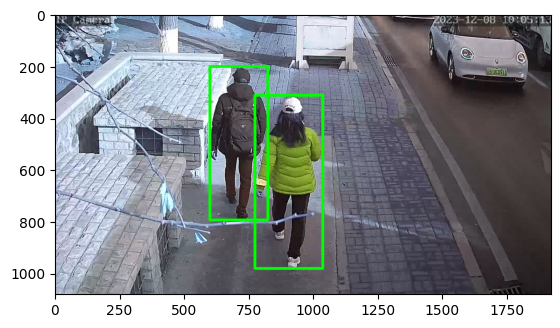

In [27]:
plt.imshow(vid2_track_results[delta_frame].orig_img)

./temp/vid2.mp4


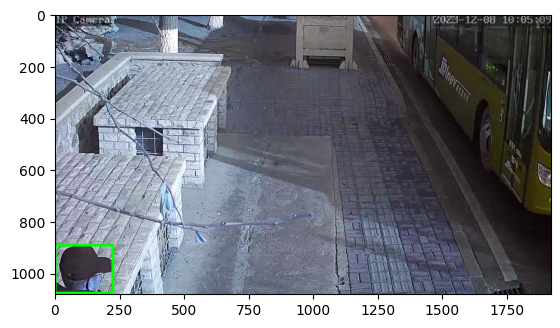

In [63]:
people_set = set()
flag = 1
color_dict = {4.: (0, 255, 0), 5.: (0, 0, 255)}
# vid1_imgs = []

# output video
output_path = './temp/'
if not os.path.exists(output_path):
    os.makedirs(output_path)
output_name = os.path.join(output_path, 'vid2.mp4')
print(output_name)

VIDEO_CODEC = "mp4v"

output_video = cv2.VideoWriter(output_name, 
                               cv2.VideoWriter_fourcc(*VIDEO_CODEC), 
                               fps, (width, height))

for fr in vid2_track_results[:]:
    box_num = fr.boxes.cls.shape[0]
    if box_num:
        # break
        flag_ = False
        for i in range(box_num):
            _, _, w, h = fr.boxes.xywh[i]
            img = fr.orig_img.copy()
            
            if (fr.boxes.id is not None) and fr.boxes.id[i].item() in [4., 5.]:
                flag_ = True
                # print(fr.boxes.id[i].item())
                # has detections and is a vertical rectangle
                # crop
                x1, y1, x2, y2 = fr.boxes.xyxy[i]
                # print(fr.boxes)
                
                # bgr to rgb
                # img = cv2.cvtColor(fr.orig_img, cv2.COLOR_BGR2RGB)

                # output_video.write(fr.plot())

                # add ori_img with box
                img = cv2.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), color_dict[fr.boxes.id[i].item()], 10)
                
                if flag:
                    flag -= 1
                    plt.imshow(img)
                    plt.show()
        if flag_:
            output_video.write(img)
output_video.release()

In [64]:
# merge two videos, left is vid1, right is vid2
vid1 = cv2.VideoCapture('./temp/' + 'vid1.mp4')
vid2 = cv2.VideoCapture('./temp/' + 'vid2.mp4')

output_path = './temp/'
if not os.path.exists(output_path):
    os.makedirs(output_path)
output_name = os.path.join(output_path, 'final.mp4')
print(output_name)

# use ffmpeg to concat all videos into a single video
cmd = f"ffmpeg -i ./temp/vid1.mp4 -i ./temp/vid2.mp4 -filter_complex hstack {output_name} -y"


./temp/final.mp4


In [65]:
os.system(cmd)

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

0